In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob 

import tensorflow as tf

plt.set_cmap('gray')

gesture_types = ["open", "close", "point", "v", "horns", "three"]


2022-03-26 22:21:57.503467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bardia/src/computer-vision/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-03-26 22:21:57.503487: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<Figure size 432x288 with 0 Axes>

## Loading data

In [3]:
def get_image(coords: np.ndarray, size = 32):
    black = np.zeros((size,size), dtype=np.int0)
    coords = np.round(coords * size).astype(np.int0) + 5 
    y = coords[:,0]
    x = coords[:,1]
    black[x,y] = 1
    return black

def get_rand_img():
    return list(set(np.random.randint(0,20, size=20)))[0:5]

def get_random_hands(gesture):
    lst = []
    for name in get_rand_img():
        img = np.loadtxt(f"./gestures/{gesture}/{str(name)}.txt")
        lst.append(img)
    return lst


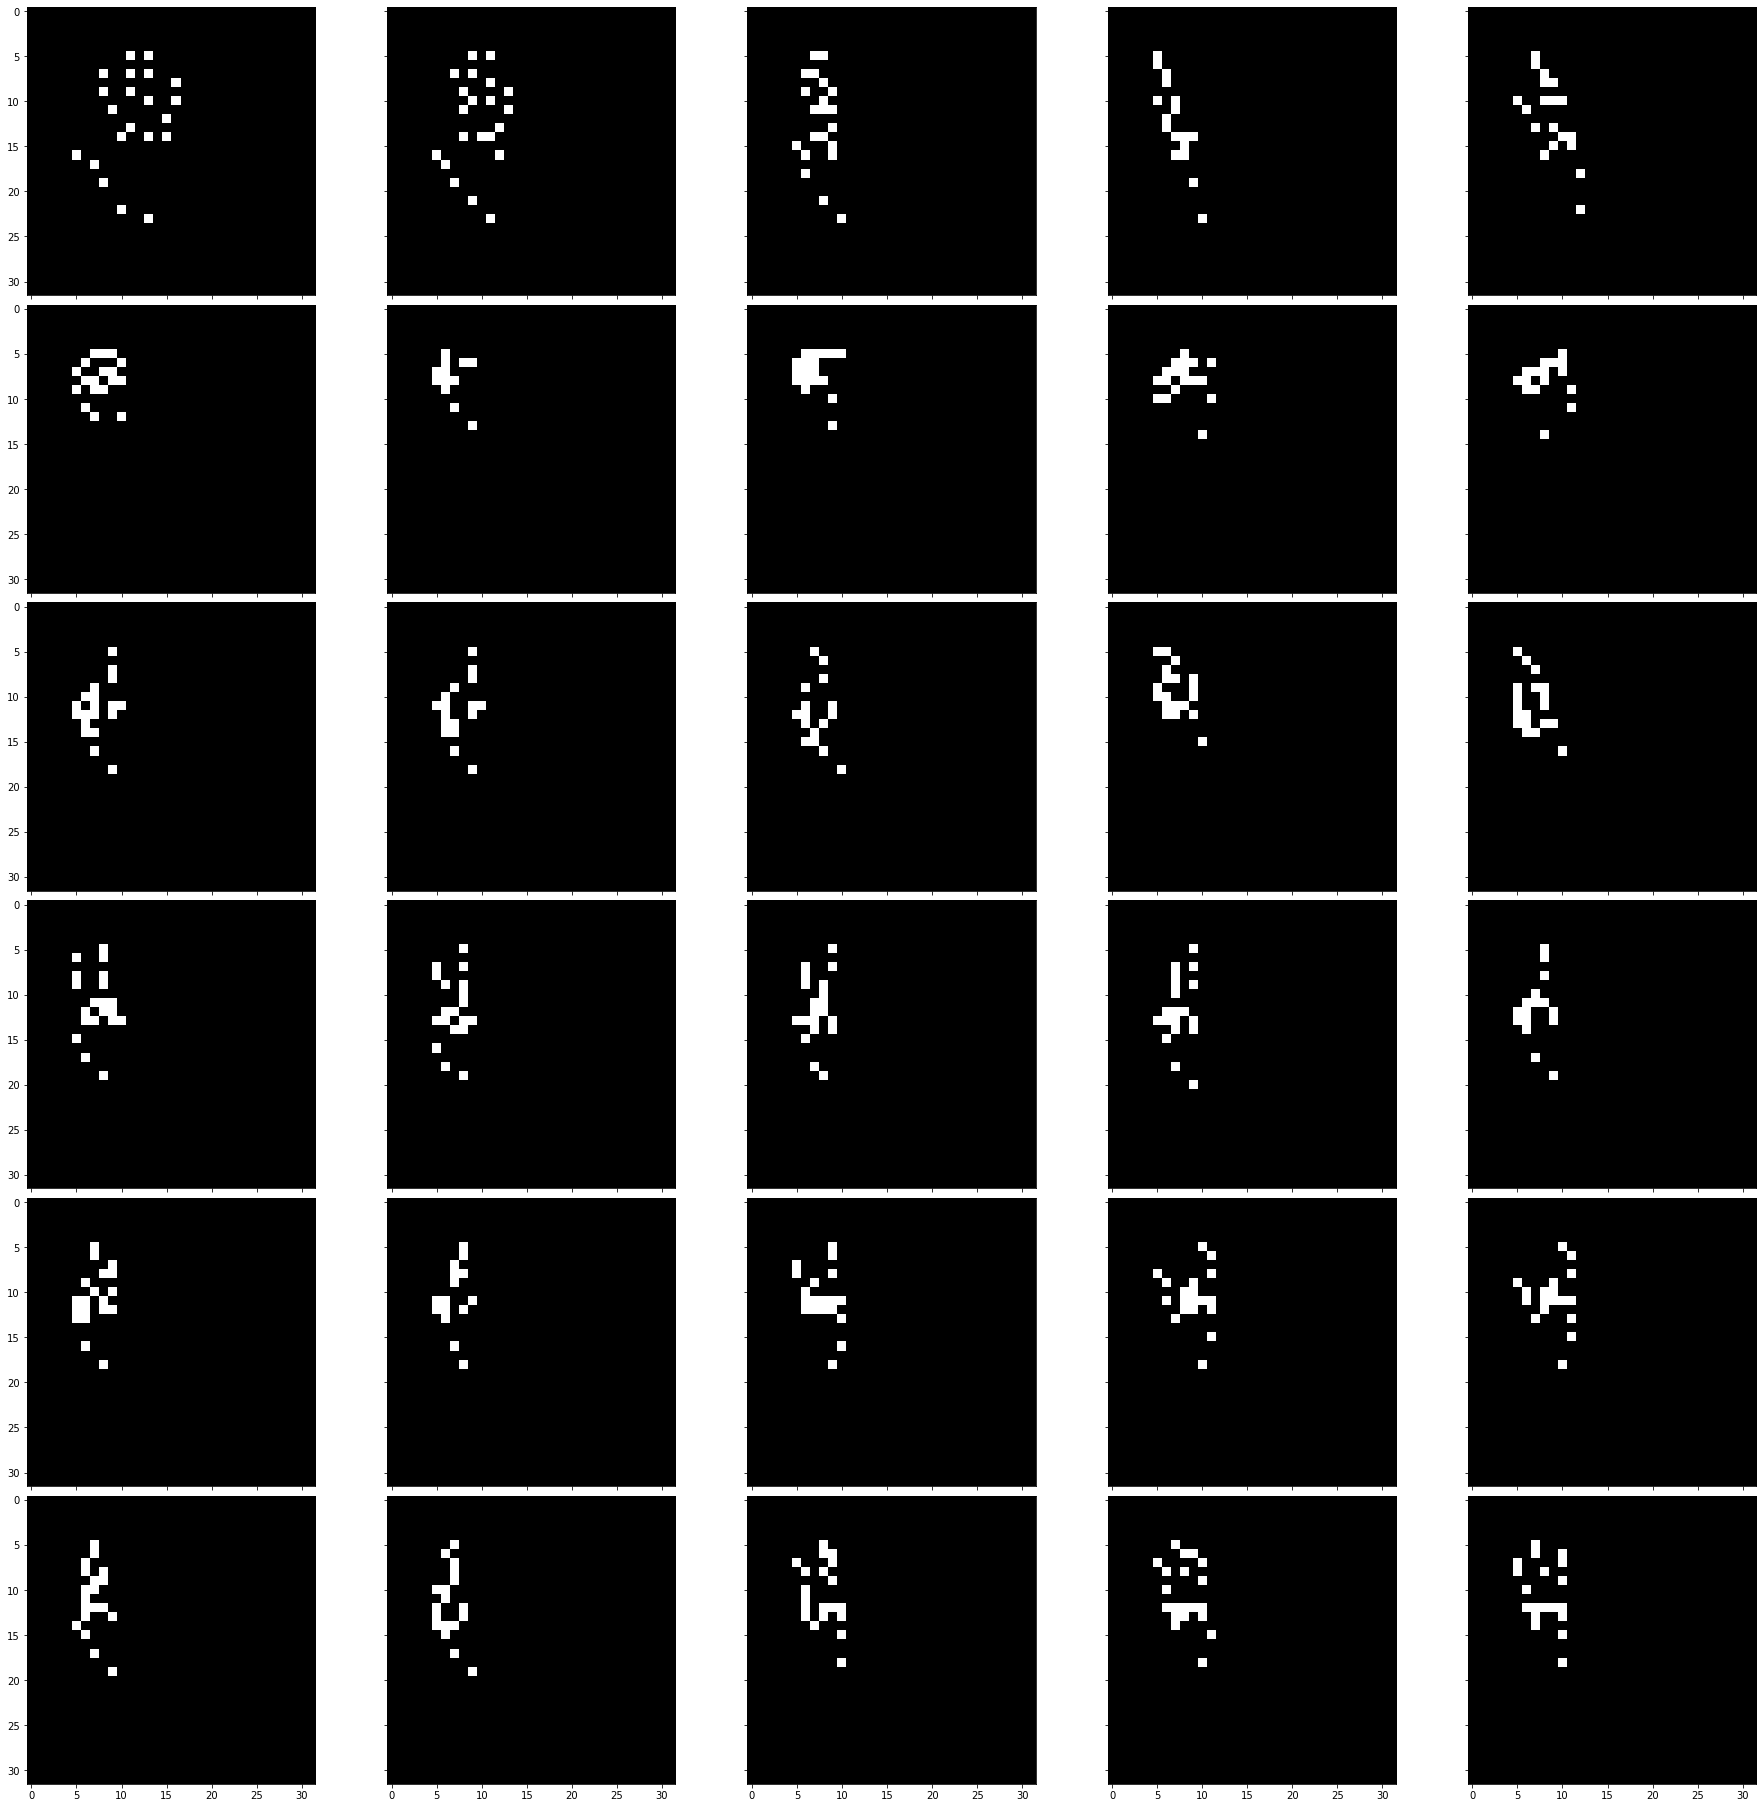

In [4]:
fig, ax = plt.subplots(len(gesture_types),5, sharey=True, sharex=True)
fig.set_constrained_layout(True)
fig.set_size_inches(5*5,5*5)

for iy, gesture_group in enumerate(gesture_types):
    gestures = get_random_hands(gesture_group)
    for ix, gesture in enumerate(gestures):
        ax[iy, ix].imshow(get_image(gesture))

## Loading model

The data contains [21 landmarks*](https://google.github.io/mediapipe/solutions/hands.html#hand-landmark-model) with normalized 2D coordinates.

In [5]:
x_train = []
y_train = []

for iy, gesture_group in enumerate(gesture_types):
    for gesture in glob.glob(f"./gestures/{gesture_group}/*.txt"):
        g = np.loadtxt(gesture)
        x_train.append(g)
        y_train.append(iy)


x_train = np.array(x_train, dtype=np.float64)
y_train = np.array(y_train, dtype=np.int0)

### Getting test Data

In [8]:
random_ix = np.random.randint(0, len(x_train), 400)

x_test = []
y_test = []

for ix in random_ix:
    x_test.append(x_train[ix])
    y_test.append(y_train[ix])


x_test = np.array(x_test, dtype=np.float64)
y_test = np.array(y_test, dtype=np.int0)

f"{x_test.shape =} - {y_test.shape = }"

'x_test.shape =(400, 21, 2) - y_test.shape = (400,)'

In [6]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(21, 2)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10),
    ]
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])


2022-03-26 22:22:00.854254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bardia/src/computer-vision/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-03-26 22:22:00.854275: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-26 22:22:00.854288: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (infinity-tuxedo): /proc/driver/nvidia/version does not exist
2022-03-26 22:22:00.854442: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flag

### Trining the model
Running 10 random sets of 100 epochs is quite fast and accurate 

In [7]:
indices = tf.range(start=0, limit=tf.shape(x_train)[0], dtype=tf.int32)

for _ in range(10):
    idx = tf.random.shuffle(indices)
    x = tf.gather(x_train, idx)
    y = tf.gather(y_train, idx)

    model.fit(x, y, epochs=100, verbose=0)


In [9]:
model.evaluate(x_test,  y_test, verbose=2)

13/13 - 0s - loss: 0.0113 - accuracy: 1.0000 - 108ms/epoch - 8ms/step


[0.011344325728714466, 1.0]

In [10]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [1]:
start = 80
end = start + 10
res = probability_model(x_test[start:end])

# if sum is not 0 we have issue
y_test[start:end] - np.argmax(res, axis=1) 


NameError: name 'probability_model' is not defined

## Testing with img data

In [12]:
from handProcessor import HandProcessor


images = [cv.imread(f) for f in glob.glob("img/*")]
hands = HandProcessor(min_detection_confidence=0.7)

def prep_subplot(l=len(images)):
    fig, ax = plt.subplots(1, l)
    fig.set_tight_layout(True)

    fig.set_size_inches(24 * 2, 24)
    [a.set_axis_off() for a in ax.ravel()]

    return fig, ax

def prep_hand(img):
    hands.proc(img)
    hand_lm = hands.get_landmark_as_np_arr()
    return hand_lm[0,:] - np.min(hand_lm[0,:], axis=0)

In [13]:
processed_images = np.array([prep_hand(img[:, ::1, ::-1]) for img in images])
res = probability_model(processed_images)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


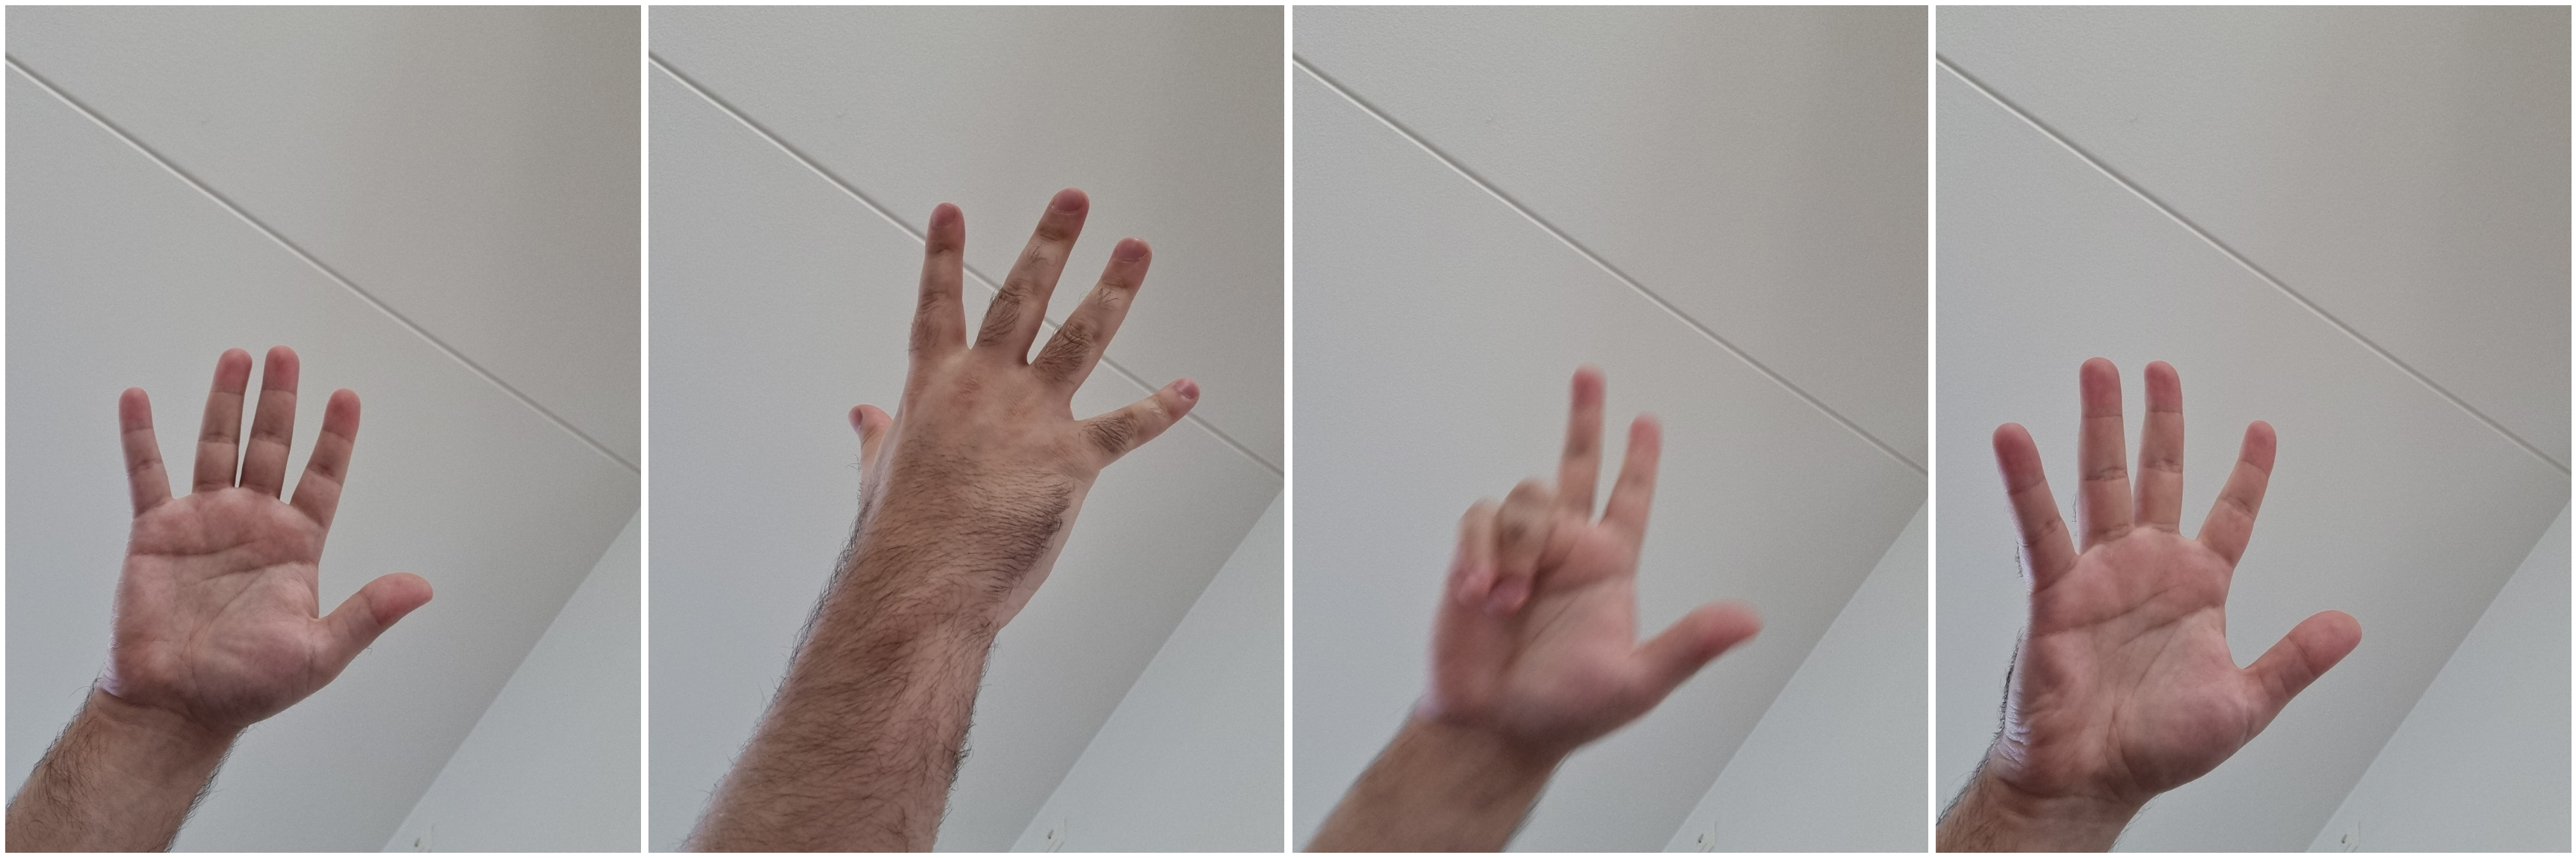

In [14]:
fig, ax = prep_subplot()
_ = [ax[ix].imshow(img[:, ::1, ::-1]) for ix, img in enumerate(images)]


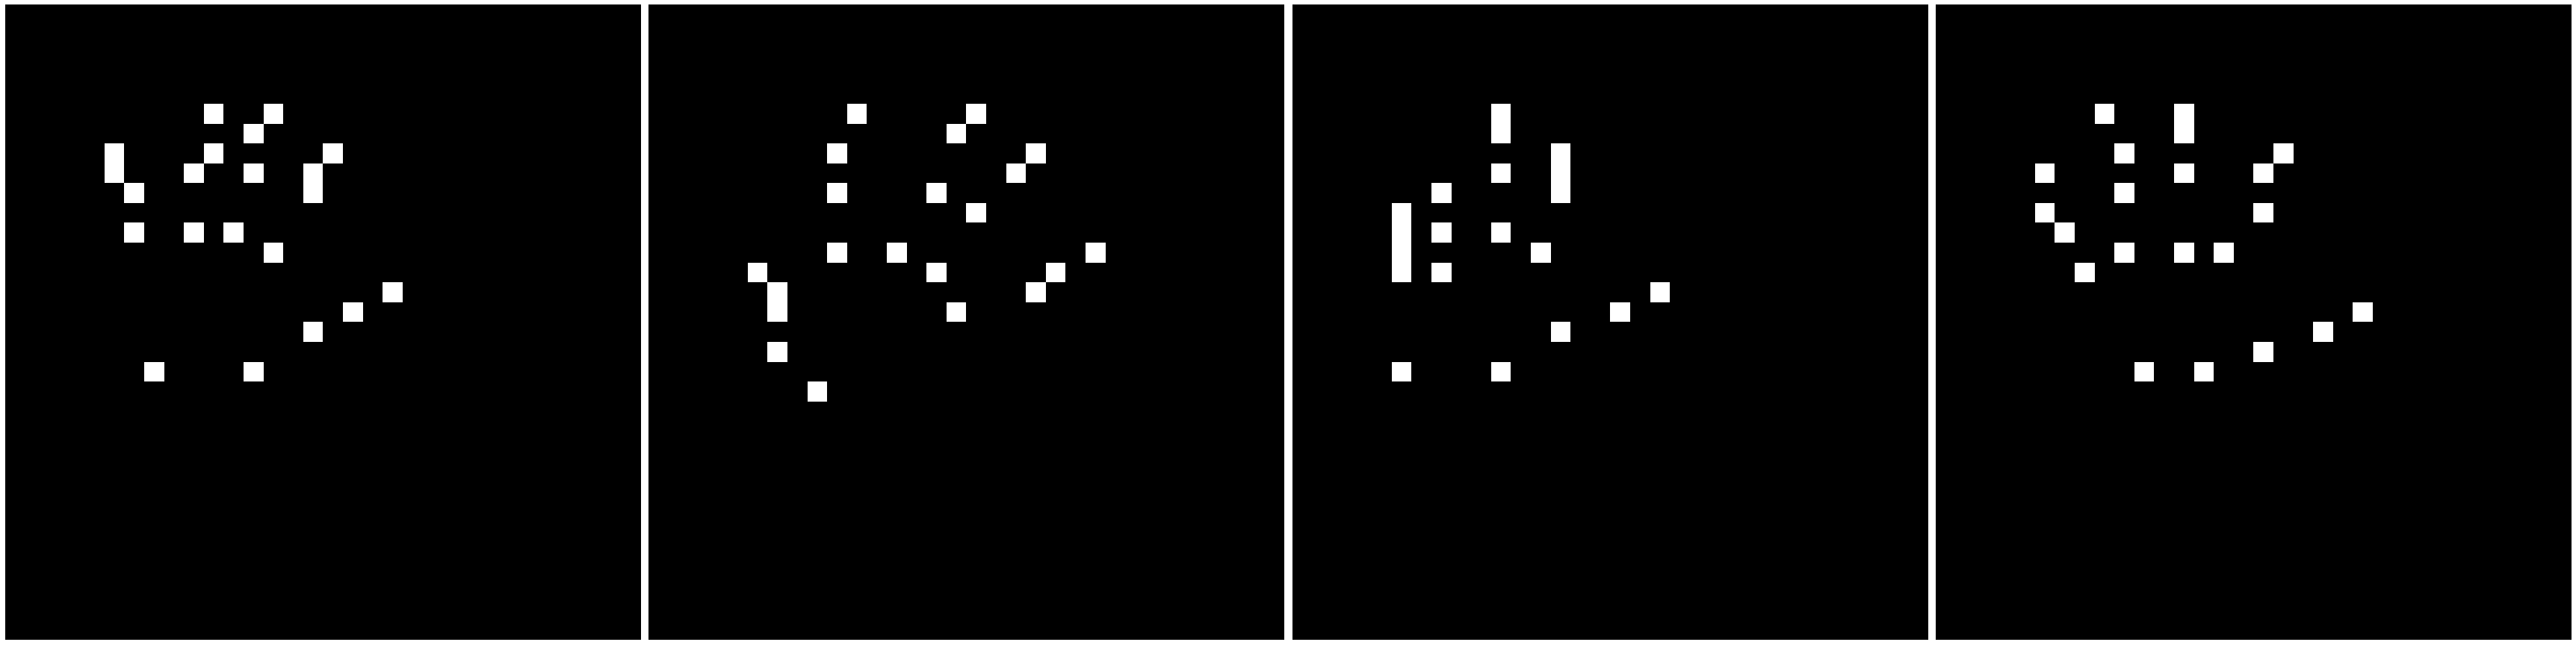

In [15]:
fig, ax = prep_subplot()
_ = [ax[ix].imshow(get_image(img)) for ix, img in enumerate(processed_images)]


In [16]:
[gesture_types[ix] for ix in np.argmax(res, axis=1)]


['open', 'open', 'three', 'open']